## Задача 3. Многоклассовая классификация и множественная классификация/регрессия

Найдите данные, на которых можно решить задачу Multiclass classification (классификация с более чем двумя классами). В крайнем случае преобразуйте данные, предназначенные для другой задачи.

In [431]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from math import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score, auc, log_loss
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier, OutputCodeClassifier
from yellowbrick.classifier import ROCAUC

from sklearn import model_selection
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

Описание датасета "Customer Segmentation":
Автомобильная компания планирует выйти на новые рынки со своей существующей продукцией (P1, P2, P3, P4 и P5). После интенсивного исследования рынка они пришли к выводу, что поведение нового рынка похоже на их существующий рынок.

На существующем рынке отдел продаж разделил всех клиентов на 4 сегмента (A, B, C, D). Затем они провели сегментированный охват и коммуникацию для разных сегментов клиентов. Эта стратегия работает исключительно хорошо для них. Они планируют использовать ту же стратегию на новых рынках и определили 2627 новых потенциальных клиентов.

* ID - Unique ID - Уникальный ID
* Gender - Gender - Пол
* Ever_Married - Marital status of the customer - Семейное положение клиента
* Age - Age - Возраст
* Graduated - Is the customer a graduate? - Является ли клиент выпускником?
* Profession - Profession - Профессия
* Work_Experience - Work Experience in years - Опыт работы в годах
* Spending_Score - Spending score - оценка расходов
* Family_Size - Family Size - Размер семьи
* Var_1 - Anonymised Category for the customer - Анонимизированная категория для клиента


Необходимо решить задачу мультиклассовой классификации и научиться предсказывать целовой признак target к какой категории относится клиент.

In [432]:
df_train = pd.read_csv('train.csv')

In [433]:
df_train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [434]:
df_train.shape

(8068, 11)

In [435]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


Выполнить разведочный анализ (EDA), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи.

In [436]:
df_train.Segmentation.value_counts()

D    2268
A    1972
C    1970
B    1858
Name: Segmentation, dtype: int64

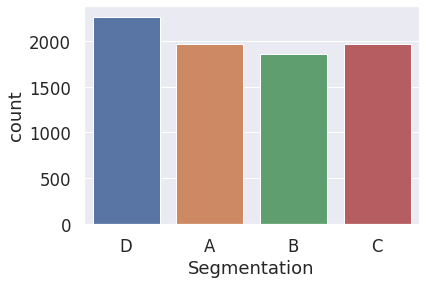

In [437]:
sns.countplot(x="Segmentation", data=df_train)
plt.show()

Из данных видно что целевая переменная сбалансирована.

In [438]:
df_num_features = df_train.select_dtypes(include=['float64', 'int64'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f08491a7460>,
      dtype=object)

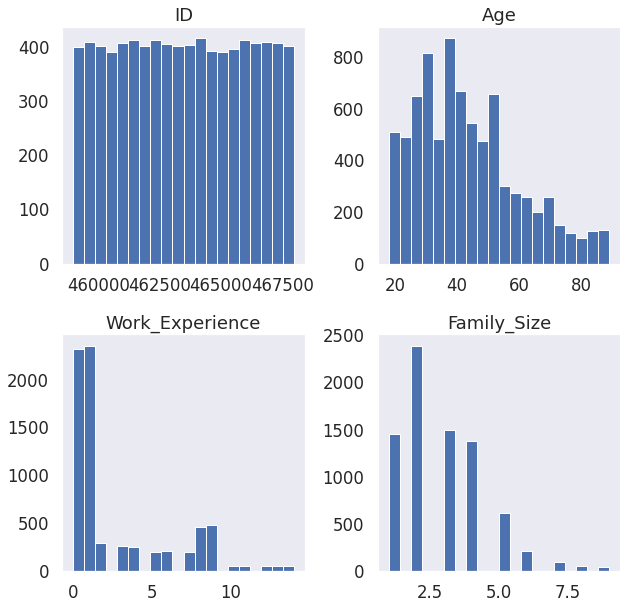

In [439]:
df_num_features.hist(figsize=(10,10), bins=20, grid=False)

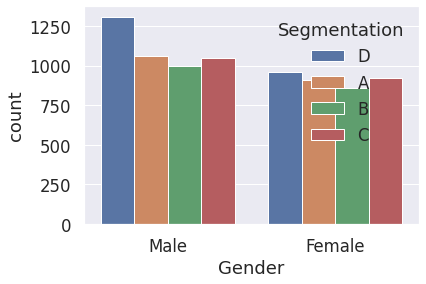

In [440]:
sns.countplot(df_train['Gender'],hue=df_train['Segmentation'])

Соотношение по категориям клиентов в зависимости от пола в количественном и процентном соотношениях.

In [441]:
groupby_df = df_train.groupby(['Gender', 'Segmentation']).agg({'Segmentation': 'count'})
groupby_pcts = groupby_df.groupby(level=0).apply(lambda x:round(100 * x / x.sum(),2))
groupby_df, groupby_pcts

(                     Segmentation
 Gender Segmentation              
 Female A                      909
        B                      861
        C                      922
        D                      959
 Male   A                     1063
        B                      997
        C                     1048
        D                     1309,                      Segmentation
 Gender Segmentation              
 Female A                    24.90
        B                    23.58
        C                    25.25
        D                    26.27
 Male   A                    24.07
        B                    22.57
        C                    23.73
        D                    29.64)

Из графика выше и показателей распределения по категорям в зависимости от пола, можно сделать вывод что пол клиента не имеет принципиального влияния на результат принадлежности к одной из категорий. Единственное исключение это мужчины в категории D, они имеют немного большее количество объектов.

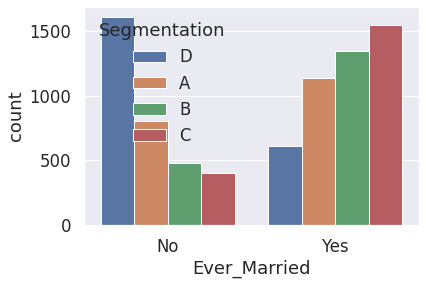

In [442]:
sns.countplot(df_train['Ever_Married'],hue=df_train['Segmentation'])

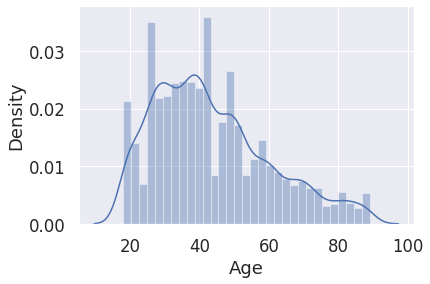

In [443]:
sns.distplot(df_train['Age'])

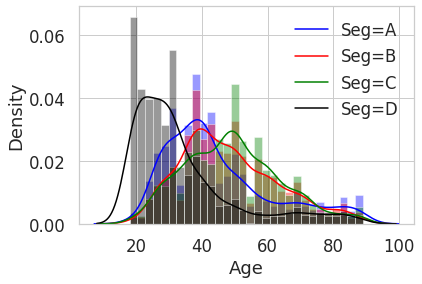

In [444]:
sns.set_style('whitegrid')
sns.distplot(df_train[df_train['Segmentation']=='A']['Age'],bins=30,color='blue')
sns.distplot(df_train[df_train['Segmentation']=='B']['Age'],bins=30,color='red')
sns.distplot(df_train[df_train['Segmentation']=='C']['Age'],bins=30,color='green')
sns.distplot(df_train[df_train['Segmentation']=='D']['Age'],bins=30,color='black')
plt.legend(labels=['Seg=A', 'Seg=B', 'Seg=C','Seg=D'])

Из графиа видно что категории C и D имеют явную зависимость от возраста клиента.

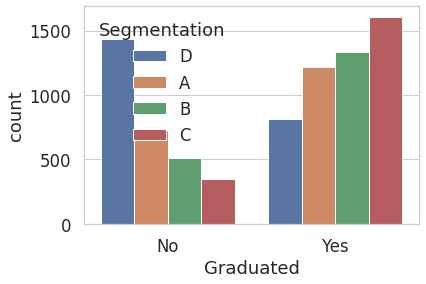

In [445]:
sns.countplot(df_train['Graduated'],hue=df_train['Segmentation'])

In [446]:
groupby_df = df_train.groupby(['Graduated', 'Segmentation']).agg({'Segmentation': 'count'})
groupby_pcts = groupby_df.groupby(level=0).apply(lambda x:round(100 * x / x.sum(),2))
groupby_df, groupby_pcts

(                        Segmentation
 Graduated Segmentation              
 No        A                      729
           B                      508
           C                      348
           D                     1437
 Yes       A                     1219
           B                     1332
           C                     1607
           D                      810,                         Segmentation
 Graduated Segmentation              
 No        A                    24.12
           B                    16.81
           C                    11.52
           D                    47.55
 Yes       A                    24.54
           B                    26.81
           C                    32.35
           D                    16.30)

Есть различие в категориях в зависимости от статуса обучения. Выпускники находятся в сегментах A, B и C, в сегменте D их меньшее количество.

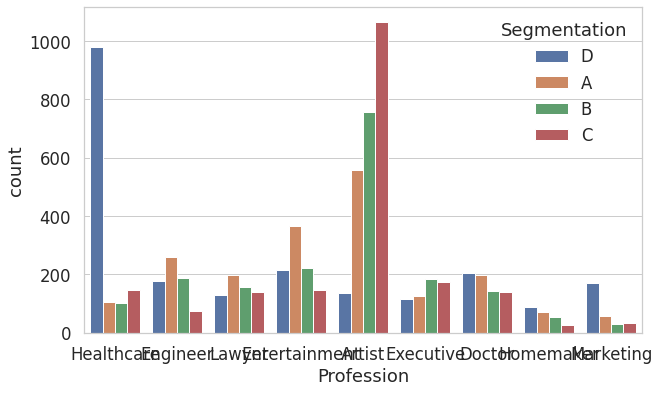

In [447]:
plt.rcParams['figure.figsize'] = (10, 6)
sns.countplot(df_train['Profession'],hue=df_train['Segmentation'])

Явное преобладание категорий A, B, C для профессий артистической сферы, а вот категория D в сфере здравоохранения.

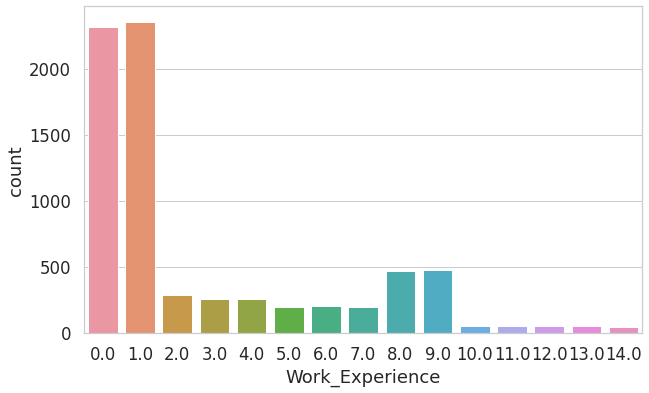

In [448]:
sns.countplot(df_train['Work_Experience'])

Среди клиентов преобладают люди с небольшим опытом работы 0-1 год. Возможно, это связано с ценой на автомобили или это целевая аудитория продавца. Например, выпускники школ, студенты, начинающие специалисты.

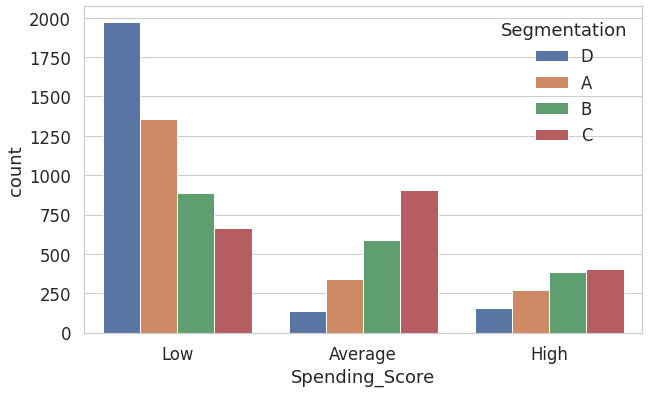

In [449]:
sns.countplot(df_train['Spending_Score'],hue=df_train['Segmentation'])

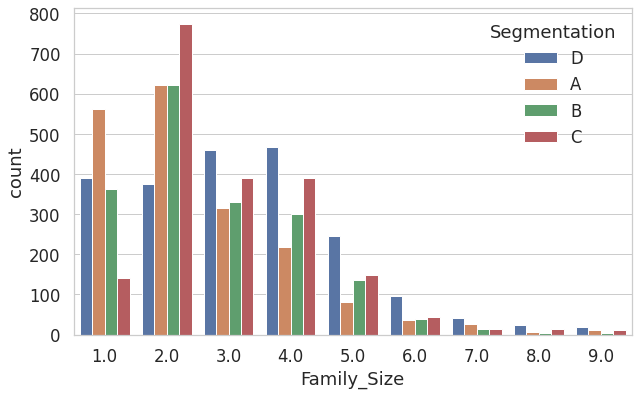

In [450]:
sns.countplot(df_train['Family_Size'],hue=df_train['Segmentation'])

Для семей, в которых 3 и более человек характерно преобладание категории D, в то время как для одиноких людей и пар характерно преобладание категорий А и С.

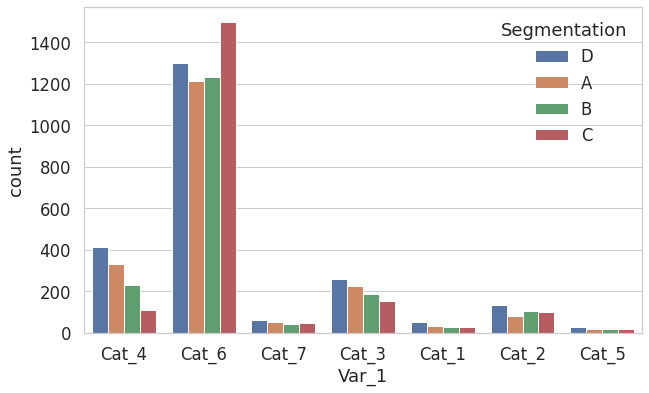

In [451]:
sns.countplot(df_train['Var_1'],hue=df_train['Segmentation'])

Поскольку категория анонимизирована, можно сделать только очевидный вывод - Cat_6 самая многочисленная категория.

#Корреляция признаков

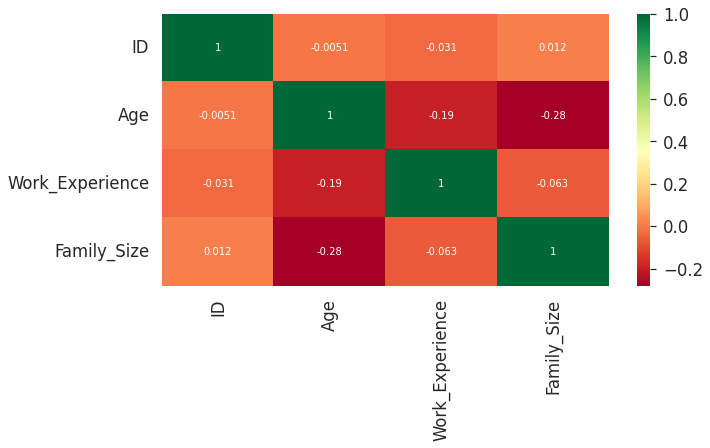

In [452]:
sns.heatmap(df_train.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

# Замена пропусков и преобразование категориальных переменных

Проверяем общее количество пропущенных значений.

In [453]:
df_train.isnull().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [454]:
df_train=pd.get_dummies(df_train,prefix='Gender',columns=['Gender'],drop_first=True)

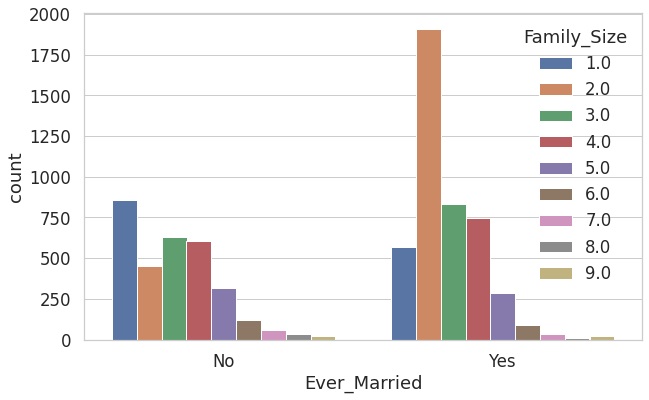

In [455]:
sns.countplot(df_train['Ever_Married'],hue=df_train['Family_Size'])

In [456]:
df_train[df_train['Ever_Married'].isnull()]['Family_Size'].value_counts()

3.0    33
2.0    28
1.0    24
4.0    22
5.0    13
6.0     5
8.0     2
7.0     1
Name: Family_Size, dtype: int64

In [457]:
df_train['Ever_Married']=df_train['Ever_Married'].fillna('Yes')

In [458]:
df_train=pd.get_dummies(df_train,prefix='Married',columns=['Ever_Married'],drop_first=True)

In [459]:
df_train['Graduated']=df_train['Graduated'].fillna('Yes')

In [460]:
df_train=pd.get_dummies(df_train,prefix='Graduated',columns=['Graduated'],drop_first=True)

In [461]:
df_train['Profession'].fillna('Unknown',inplace=True)

In [462]:
df_train['Profession']=df_train['Profession'].astype('str')

In [463]:
le = preprocessing.LabelEncoder()
df_train['Profession_en']=le.fit_transform(df_train['Profession'])

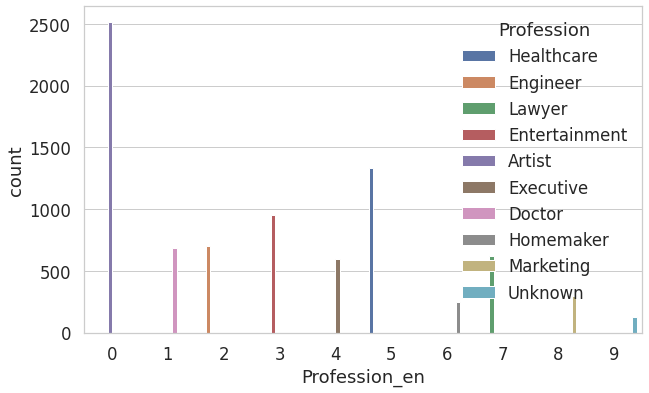

In [464]:
sns.countplot(df_train['Profession_en'],hue=df_train['Profession'])

In [465]:
df_train['Profession_en'].value_counts()

0    2516
5    1332
3     949
2     699
1     688
7     623
4     599
8     292
6     246
9     124
Name: Profession_en, dtype: int64

In [466]:
df_train.drop('Profession',axis=1,inplace=True)

In [467]:
df_train['Work_Experience'].fillna(df_train['Work_Experience'].mean(),inplace=True)

In [468]:
df_train.loc[df_train['Spending_Score']=='Low','Spending_Score']=1
df_train.loc[df_train['Spending_Score']=='Average','Spending_Score']=2
df_train.loc[df_train['Spending_Score']=='High','Spending_Score']=3
df_train['Spending_Score']=df_train['Spending_Score'].astype('int')

In [469]:
df_train['Family_Size'].fillna(round(df_train['Family_Size'].mean()),inplace=True)

In [470]:
df_train['Var_1'].fillna('Cat_6',inplace=True)
df_train['Var_1']=df_train['Var_1'].apply(lambda x:x[-1])
df_train['Var_1']=df_train['Var_1'].astype('int')

In [471]:
df_train['Segmentation']=le.fit_transform(df_train['Segmentation'])

In [472]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Age              8068 non-null   int64  
 2   Work_Experience  8068 non-null   float64
 3   Spending_Score   8068 non-null   int64  
 4   Family_Size      8068 non-null   float64
 5   Var_1            8068 non-null   int64  
 6   Segmentation     8068 non-null   int64  
 7   Gender_Male      8068 non-null   uint8  
 8   Married_Yes      8068 non-null   uint8  
 9   Graduated_Yes    8068 non-null   uint8  
 10  Profession_en    8068 non-null   int64  
dtypes: float64(2), int64(6), uint8(3)
memory usage: 528.0 KB


### Разбиение данных с использованием train_test_split и масштабирование

В датасете остались только числовые признаки, поэтому масштабируем весь набор данных.

In [473]:
y = df_train['Segmentation']
X = df_train.drop(columns=['Segmentation'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

scaler = StandardScaler()  # воспользуемся стандартным трансформером

# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train_scaled = scaler.fit_transform(X_train)

# масштабируем тестовую выборку используя статистики обучающей выборки
X_test_scaled = scaler.transform(X_test)

### Используя стратегии OneVsRest, OneVsOne и OutputCode решите задачу Multiclass classification для каждого из пройденных базового алгоритма классификации (logistic regression, svm, knn, naive bayes, decision tree). При обучении использовать подбор гиперпараметров, кросс-валидацию и при необходимости масштабирование данных, добиться наилучшего качества предсказания.

In [474]:
df_result = pd.DataFrame(columns=['ROC_AUC', 'time'])

## Logistic regression

Optimal number of features: 9
Selected features: ['Age', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1', 'Gender_Male', 'Married_Yes', 'Graduated_Yes', 'Profession_en']


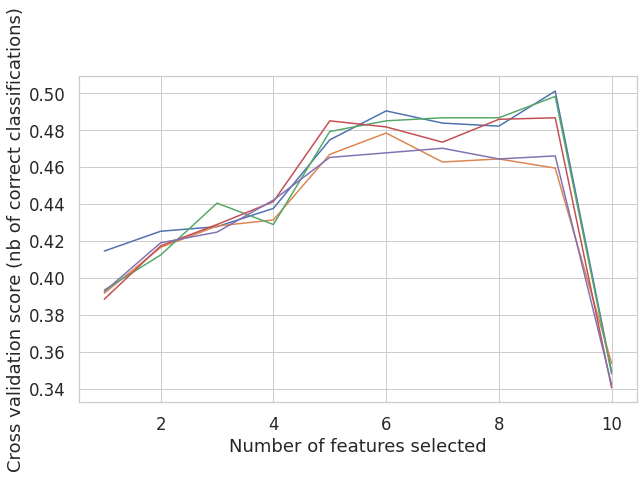

In [475]:
rfecv = RFECV(estimator=OneVsRestClassifier(LogisticRegression()), step=1, cv=5, scoring='accuracy')
rfecv = rfecv.fit(X_train, y_train)

selected_features = list(X_train.columns[rfecv.support_])

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % selected_features)

plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Optimal number of features: 9
Selected features: ['Age', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1', 'Gender_Male', 'Married_Yes', 'Graduated_Yes', 'Profession_en']


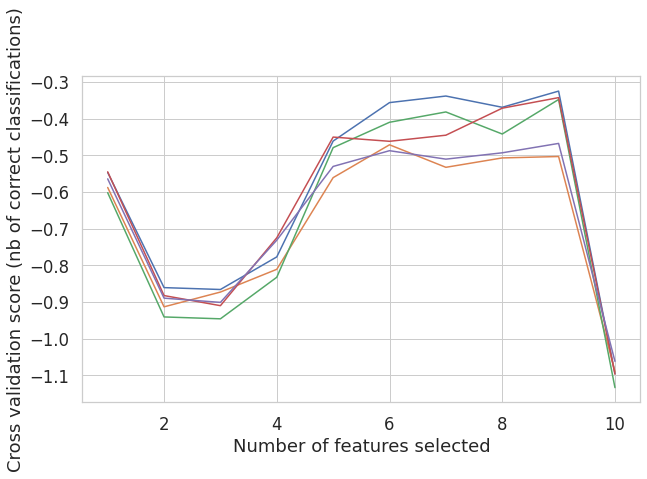

In [476]:
rfecv = RFECV(estimator=OneVsRestClassifier(LogisticRegression()), step=1, cv=5, scoring='r2')
rfecv = rfecv.fit(X_train, y_train)

selected_features = list(X_train.columns[rfecv.support_])

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % selected_features)

plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Выбор оптимального количества признаков кросс-валидацией с помощью RFECV двумя выбранными скорингами (accuracy и r2) показывает одинаковые результаты. Предлагается использовать 9 признаков датасета.

In [477]:
classifier = OneVsRestClassifier(LogisticRegression())
#запустим кросс-валидацию
cv_scores = cross_val_score(LogisticRegression(), X_train_scaled, y_train, cv=5, scoring='accuracy')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))
start_time = time.time()
y_score = classifier.fit(X_train_scaled, y_train).predict(X_test_scaled)
t = (time.time() - start_time)

CV score is 0.49214951102497084+-0.012766047782026514


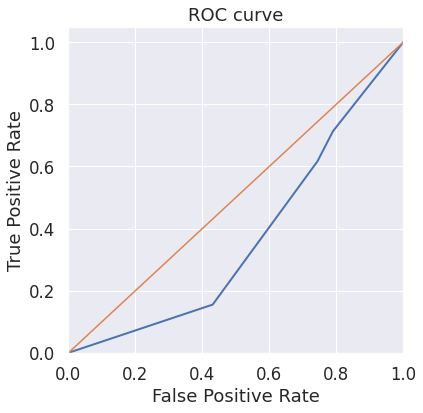

In [478]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(6, 6))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [479]:
print("roc auc score: {}".format(roc_auc_score(y_test, classifier.predict_proba(X_test_scaled), multi_class='ovr')))
roc = '%.3f' % (roc_auc_score(y_test, classifier.predict_proba(X_test_scaled), multi_class='ovr'))

roc auc score: 0.7292363044459543


In [480]:
df_result.loc['Logistic_regression_OvR'] = [roc, '%.3f'%t ]

In [481]:
classifier = OneVsOneClassifier(LogisticRegression(random_state=11))

start_time = time.time()
y_score = classifier.fit(X_train_scaled, y_train).predict(X_test_scaled)
t = (time.time() - start_time)

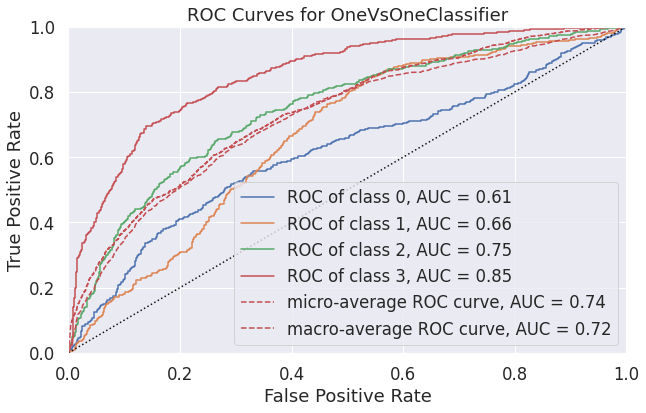

In [482]:
visualizer = ROCAUC(classifier, classes=[0, 1, 2, 3])
visualizer.fit(X_train_scaled, y_train)       
visualizer.score(X_test_scaled, y_test)        
visualizer.show()  

In [483]:
roc = visualizer.score_
df_result.loc['Logistic_regression_OvO'] = ['%.3f'%roc, '%.3f'%t]

In [484]:
classifier = OutputCodeClassifier(LogisticRegression(random_state=11), code_size=2, random_state=42)
start_time = time.time()
y_score = classifier.fit(X_train_scaled, y_train).predict(X_test_scaled)
t = (time.time() - start_time)

In [485]:
predict_0 = [1 if y == 0 else 0 for y in y_score] 
predict_1 = [1 if y == 1 else 0 for y in y_score] 
predict_2 = [1 if y == 2 else 0 for y in y_score]
predict_3 = [1 if y == 3 else 0 for y in y_score]
predicts = [predict_0,predict_1,predict_2, predict_3]
y_test_0 = [1 if y == 0 else 0 for y in y_test] 
y_test_1 = [1 if y == 1 else 0 for y in y_test] 
y_test_2 = [1 if y == 2 else 0 for y in y_test] 
y_test_3 = [1 if y == 3 else 0 for y in y_test] 
y_tests = [y_test_0,y_test_1,y_test_2, y_test_3]
model_scores = np.zeros(4)
for i in range (0,4):
    model_scores[i] = roc_auc_score(y_tests[i],predicts[i])
roc = model_scores.mean()

In [486]:
df_result.loc['Logistic_regression_OCode'] = ['%.3f'%roc, '%.3f'%t]

## Support Vector Machine (SVM)

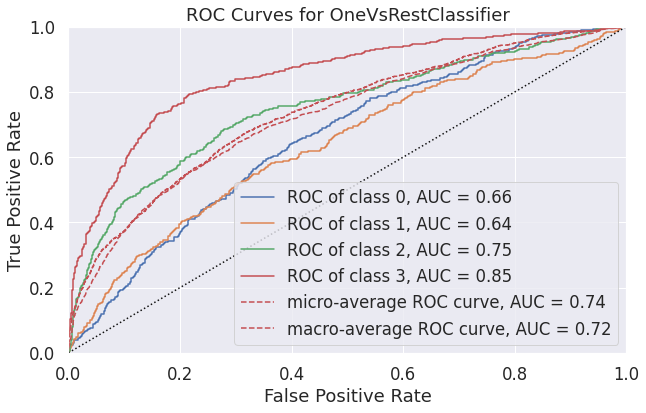

In [487]:
classifier = OneVsRestClassifier(SVC(random_state = 12))
start_time = time.time()
y_score = classifier.fit(X_train_scaled, y_train).predict(X_test_scaled)
t = (time.time() - start_time)
visualizer = ROCAUC(classifier, classes=[0, 1, 2, 3])
visualizer.fit(X_train_scaled, y_train)       
visualizer.score(X_test_scaled, y_test)        
visualizer.show()  
roc = visualizer.score_
df_result.loc['SVM_OvR'] = ['%.3f'%roc, '%.3f'%t]

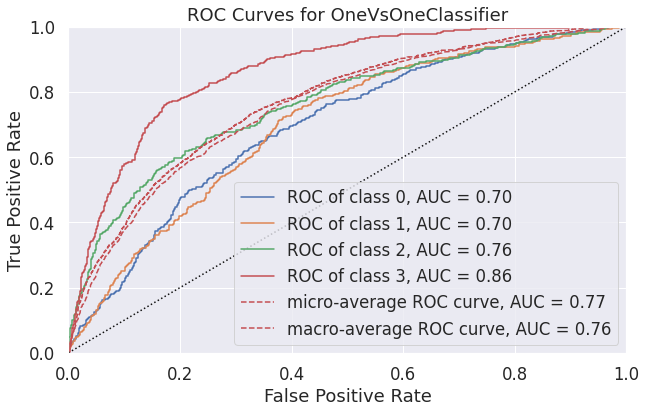

In [488]:
classifier = OneVsOneClassifier(SVC(random_state = 12))
start_time = time.time()
y_score = classifier.fit(X_train_scaled, y_train).predict(X_test_scaled)
t = (time.time() - start_time)
visualizer = ROCAUC(classifier, classes=[0, 1, 2, 3])
visualizer.fit(X_train_scaled, y_train)       
visualizer.score(X_test_scaled, y_test)        
visualizer.show()  
roc = visualizer.score_
df_result.loc['SVM_OvO'] = ['%.3f'%roc, '%.3f'%t]

In [489]:
classifier = OutputCodeClassifier(SVC(random_state = 12), code_size=2, random_state=42)
start_time = time.time()
y_score = classifier.fit(X_train_scaled, y_train).predict(X_test_scaled)
t = (time.time() - start_time)
predict_0 = [1 if y == 0 else 0 for y in y_score] 
predict_1 = [1 if y == 1 else 0 for y in y_score] 
predict_2 = [1 if y == 2 else 0 for y in y_score]
predict_3 = [1 if y == 3 else 0 for y in y_score]
predicts = [predict_0,predict_1,predict_2, predict_3]
y_test_0 = [1 if y == 0 else 0 for y in y_test] 
y_test_1 = [1 if y == 1 else 0 for y in y_test] 
y_test_2 = [1 if y == 2 else 0 for y in y_test] 
y_test_3 = [1 if y == 3 else 0 for y in y_test] 
y_tests = [y_test_0,y_test_1,y_test_2, y_test_3]
model_scores = np.zeros(4)
for i in range (0,4):
    model_scores[i] = roc_auc_score(y_tests[i],predicts[i])
roc = model_scores.mean()
df_result.loc['SVM_OCode'] = ['%.3f'%roc, '%.3f'%t]

## K-Nearest Neighbour (KNN) Classification

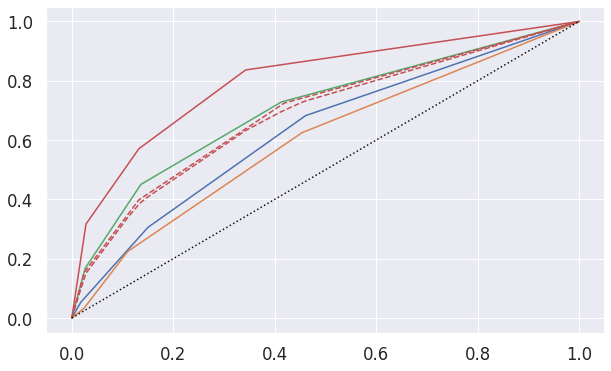

In [490]:
classifier = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 3))
start_time = time.time()
y_score = classifier.fit(X_train_scaled, y_train).predict(X_test_scaled)
t = (time.time() - start_time)
visualizer = ROCAUC(classifier, classes=[0, 1, 2, 3])
visualizer.fit(X_train_scaled, y_train)       
visualizer.score(X_test_scaled, y_test)        
roc = visualizer.score_
df_result.loc['KNN_OvR'] = ['%.3f'%roc, '%.3f'%t]

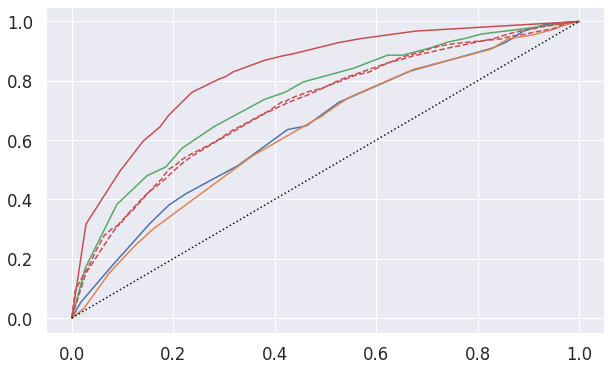

In [491]:
classifier = OneVsOneClassifier(KNeighborsClassifier(n_neighbors = 3))
start_time = time.time()
y_score = classifier.fit(X_train_scaled, y_train).predict(X_test_scaled)
t = (time.time() - start_time)
visualizer = ROCAUC(classifier, classes=[0, 1, 2, 3])
visualizer.fit(X_train_scaled, y_train)       
visualizer.score(X_test_scaled, y_test)        
roc = visualizer.score_
df_result.loc['KNN_OvO'] = ['%.3f'%roc, '%.3f'%t]

In [492]:
classifier = OutputCodeClassifier(KNeighborsClassifier(n_neighbors = 3), code_size=2, random_state=42)
start_time = time.time()
y_score = classifier.fit(X_train_scaled, y_train).predict(X_test_scaled)
t = (time.time() - start_time)
predict_0 = [1 if y == 0 else 0 for y in y_score] 
predict_1 = [1 if y == 1 else 0 for y in y_score] 
predict_2 = [1 if y == 2 else 0 for y in y_score]
predict_3 = [1 if y == 3 else 0 for y in y_score]
predicts = [predict_0,predict_1,predict_2, predict_3]
y_test_0 = [1 if y == 0 else 0 for y in y_test] 
y_test_1 = [1 if y == 1 else 0 for y in y_test] 
y_test_2 = [1 if y == 2 else 0 for y in y_test] 
y_test_3 = [1 if y == 3 else 0 for y in y_test] 
y_tests = [y_test_0,y_test_1,y_test_2, y_test_3]
model_scores = np.zeros(4)
for i in range (0,4):
    model_scores[i] = roc_auc_score(y_tests[i],predicts[i])
roc = model_scores.mean()
df_result.loc['KNN_OCode'] = ['%.3f'%roc, '%.3f'%t]

## Naive Bayes Algorithm

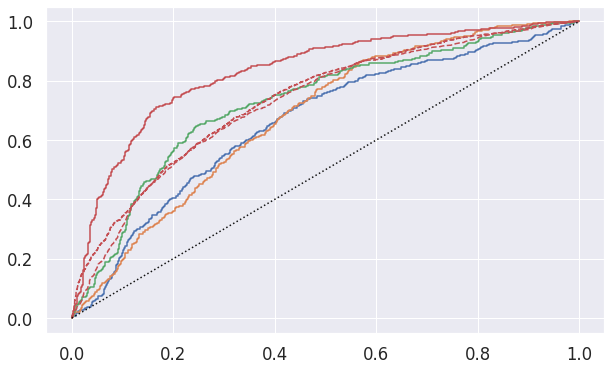

In [493]:
classifier = OneVsRestClassifier(GaussianNB())
start_time = time.time()
y_score = classifier.fit(X_train_scaled, y_train).predict(X_test_scaled)
t = (time.time() - start_time)
visualizer = ROCAUC(classifier, classes=[0, 1, 2, 3])
visualizer.fit(X_train_scaled, y_train)       
visualizer.score(X_test_scaled, y_test)        
roc = visualizer.score_
df_result.loc['Naive_Bayes_OvR'] = ['%.3f'%roc, '%.3f'%t]

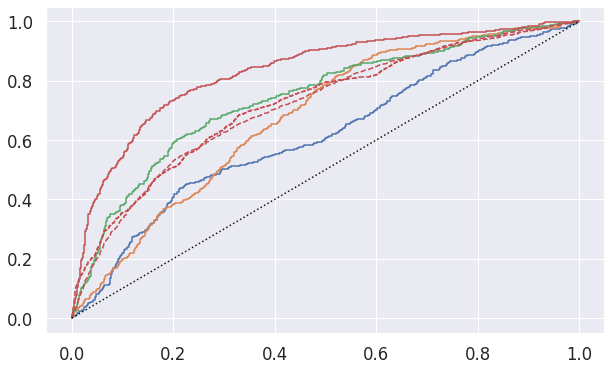

In [494]:
classifier = OneVsOneClassifier(GaussianNB())
start_time = time.time()
y_score = classifier.fit(X_train_scaled, y_train).predict(X_test_scaled)
t = (time.time() - start_time)
visualizer = ROCAUC(classifier, classes=[0, 1, 2, 3])
visualizer.fit(X_train_scaled, y_train)       
visualizer.score(X_test_scaled, y_test)        
roc = visualizer.score_
df_result.loc['Naive_Bayes_OvO'] = ['%.3f'%roc, '%.3f'%t]

In [495]:
classifier = OutputCodeClassifier(GaussianNB())
start_time = time.time()
y_score = classifier.fit(X_train_scaled, y_train).predict(X_test_scaled)
t = (time.time() - start_time)
predict_0 = [1 if y == 0 else 0 for y in y_score] 
predict_1 = [1 if y == 1 else 0 for y in y_score] 
predict_2 = [1 if y == 2 else 0 for y in y_score]
predict_3 = [1 if y == 3 else 0 for y in y_score]
predicts = [predict_0,predict_1,predict_2, predict_3]
y_test_0 = [1 if y == 0 else 0 for y in y_test] 
y_test_1 = [1 if y == 1 else 0 for y in y_test] 
y_test_2 = [1 if y == 2 else 0 for y in y_test] 
y_test_3 = [1 if y == 3 else 0 for y in y_test] 
y_tests = [y_test_0,y_test_1,y_test_2, y_test_3]
model_scores = np.zeros(4)
for i in range (0,4):
    model_scores[i] = roc_auc_score(y_tests[i],predicts[i])
roc = model_scores.mean()
df_result.loc['Naive_Bayes_OCode'] = ['%.3f'%roc, '%.3f'%t]

## Decision Tree Algorithm

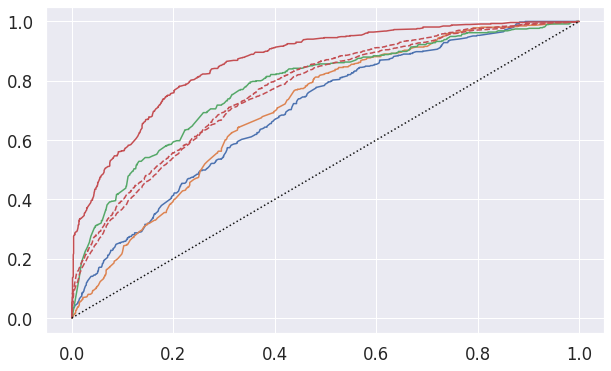

In [496]:
classifier = OneVsRestClassifier(DecisionTreeClassifier(max_depth=5, max_features=6, min_samples_leaf=6))
start_time = time.time()
y_score = classifier.fit(X_train, y_train).predict(X_test)
t = (time.time() - start_time)
visualizer = ROCAUC(classifier, classes=[0, 1, 2, 3])
visualizer.fit(X_train, y_train)       
visualizer.score(X_test, y_test)        
roc = visualizer.score_
df_result.loc['Decision_Tree_OvR'] = ['%.3f'%roc, '%.3f'%t]

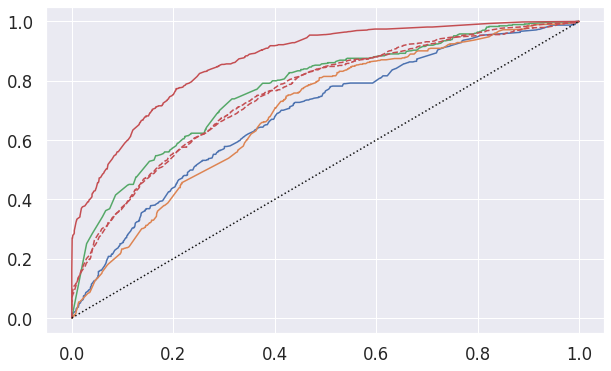

In [497]:
classifier = OneVsOneClassifier(DecisionTreeClassifier(max_depth=5, max_features=6, min_samples_leaf=6))
start_time = time.time()
y_score = classifier.fit(X_train, y_train).predict(X_test)
t = (time.time() - start_time)
visualizer = ROCAUC(classifier, classes=[0, 1, 2, 3])
visualizer.fit(X_train, y_train)       
visualizer.score(X_test, y_test)        
roc = visualizer.score_
df_result.loc['Decision_Tree_OvO'] = ['%.3f'%roc, '%.3f'%t]

In [498]:
classifier = OutputCodeClassifier(DecisionTreeClassifier(max_depth=5, max_features=6, min_samples_leaf=6))
start_time = time.time()
y_score = classifier.fit(X_train, y_train).predict(X_test)
t = (time.time() - start_time)
predict_0 = [1 if y == 0 else 0 for y in y_score] 
predict_1 = [1 if y == 1 else 0 for y in y_score] 
predict_2 = [1 if y == 2 else 0 for y in y_score]
predict_3 = [1 if y == 3 else 0 for y in y_score]
predicts = [predict_0,predict_1,predict_2, predict_3]
y_test_0 = [1 if y == 0 else 0 for y in y_test] 
y_test_1 = [1 if y == 1 else 0 for y in y_test] 
y_test_2 = [1 if y == 2 else 0 for y in y_test] 
y_test_3 = [1 if y == 3 else 0 for y in y_test] 
y_tests = [y_test_0,y_test_1,y_test_2, y_test_3]
model_scores = np.zeros(4)
for i in range (0,4):
    model_scores[i] = roc_auc_score(y_tests[i],predicts[i])
roc = model_scores.mean()
df_result.loc['Decision_Tree_OCode'] = ['%.3f'%roc, '%.3f'%t]

In [499]:
df_result

,ROC_AUC,time
Logistic_regression_OvR,0.729,0.076
Logistic_regression_OvO,0.720,0.106
Logistic_regression_OCode,0.631,0.164
SVM_OvR,0.723,7.912
SVM_OvO,0.756,5.270
SVM_OCode,0.640,12.585
KNN_OvR,0.685,0.302
KNN_OvO,0.711,0.929
KNN_OCode,0.634,0.442
Naive_Bayes_OvR,0.725,0.017


Из полученных результатов видно что наилучшие показатели и ROC-AUC и затраченного на обучение времени по всем стратегиям Multiclass classification показывает Decision tree. 

### Повторить все пункты для задачи Multilabel classification (классификация с несколькими целевыми признаками, например, бинарными). В качестве стратегий попробовать MultiOutputClassifier и ClassifierChain.

In [500]:
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain

In [501]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Age              8068 non-null   int64  
 2   Work_Experience  8068 non-null   float64
 3   Spending_Score   8068 non-null   int64  
 4   Family_Size      8068 non-null   float64
 5   Var_1            8068 non-null   int64  
 6   Segmentation     8068 non-null   int64  
 7   Gender_Male      8068 non-null   uint8  
 8   Married_Yes      8068 non-null   uint8  
 9   Graduated_Yes    8068 non-null   uint8  
 10  Profession_en    8068 non-null   int64  
dtypes: float64(2), int64(6), uint8(3)
memory usage: 528.0 KB


In [502]:
df_train=pd.get_dummies(df_train, columns=['Segmentation'])

In [503]:
X = df_train.drop(['Segmentation_0', 'Segmentation_1', 'Segmentation_2', 'Segmentation_3'], axis=1)
y = df_train[['Segmentation_0', 'Segmentation_1', 'Segmentation_2', 'Segmentation_3']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [504]:
scaler = StandardScaler()  # воспользуемся стандартным трансформером

# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train_scaled = scaler.fit_transform(X_train)

# масштабируем тестовую выборку используя статистики обучающей выборки
X_test_scaled = scaler.transform(X_test)

In [505]:
df_result_2 = pd.DataFrame(columns=['Score', 'time'])

In [506]:
classifier = MultiOutputClassifier(LogisticRegression(random_state = 42))
start_time = time.time()
y_score = classifier.fit(X_train_scaled, y_train).predict(X_test_scaled)
t = (time.time() - start_time)
sc = classifier.score(X_test_scaled, y_test)      
df_result_2.loc['Logistic_Regression_MOC'] = ['%.3f'%sc, '%.3f'%t]

In [507]:
classifier = ClassifierChain(LogisticRegression(random_state = 42))
start_time = time.time()
y_score = classifier.fit(X_train_scaled, y_train).predict(X_test_scaled)
t = (time.time() - start_time)
sc = classifier.score(X_test_scaled, y_test)      
df_result_2.loc['Logistic_Regression_CC'] = ['%.3f'%sc, '%.3f'%t]

In [508]:
classifier = MultiOutputClassifier(SVC(random_state = 12))
start_time = time.time()
y_score = classifier.fit(X_train_scaled, y_train).predict(X_test_scaled)
t = (time.time() - start_time)
sc = classifier.score(X_test_scaled, y_test)      
df_result_2.loc['SVM_MOC'] = ['%.3f'%sc, '%.3f'%t]

In [509]:
classifier = ClassifierChain(SVC(random_state = 12))
start_time = time.time()
y_score = classifier.fit(X_train_scaled, y_train).predict(X_test_scaled)
t = (time.time() - start_time)
sc = classifier.score(X_test_scaled, y_test)      
df_result_2.loc['SVM_CC'] = ['%.3f'%sc, '%.3f'%t]

In [510]:
classifier = MultiOutputClassifier(KNeighborsClassifier(n_neighbors = 3))
start_time = time.time()
y_score = classifier.fit(X_train_scaled, y_train).predict(X_test_scaled)
t = (time.time() - start_time)
sc = classifier.score(X_test_scaled, y_test)      
df_result_2.loc['KNN_MOC'] = ['%.3f'%sc, '%.3f'%t]

In [511]:
classifier = ClassifierChain(KNeighborsClassifier(n_neighbors = 3))
start_time = time.time()
y_score = classifier.fit(X_train_scaled, y_train).predict(X_test_scaled)
t = (time.time() - start_time)
sc = classifier.score(X_test_scaled, y_test)      
df_result_2.loc['KNN_CC'] = ['%.3f'%sc, '%.3f'%t]

In [512]:
classifier = MultiOutputClassifier(GaussianNB())
start_time = time.time()
y_score = classifier.fit(X_train_scaled, y_train).predict(X_test_scaled)
t = (time.time() - start_time)
sc = classifier.score(X_test_scaled, y_test)      
df_result_2.loc['Naiv_B_MOC'] = ['%.3f'%sc, '%.3f'%t]

In [513]:
classifier = ClassifierChain(GaussianNB())
start_time = time.time()
y_score = classifier.fit(X_train_scaled, y_train).predict(X_test_scaled)
t = (time.time() - start_time)
sc = classifier.score(X_test_scaled, y_test)      
df_result_2.loc['Naiv_B_CC'] = ['%.3f'%sc, '%.3f'%t]

In [514]:
classifier = MultiOutputClassifier(DecisionTreeClassifier(max_depth=5, max_features=6, min_samples_leaf=6))
start_time = time.time()
y_score = classifier.fit(X_train, y_train).predict(X_test)
t = (time.time() - start_time)
sc = classifier.score(X_test, y_test)      
df_result_2.loc['Dec_Tree_MOC'] = ['%.3f'%sc, '%.3f'%t]

In [515]:
classifier = ClassifierChain(DecisionTreeClassifier(max_depth=5, max_features=6, min_samples_leaf=6))
start_time = time.time()
y_score = classifier.fit(X_train, y_train).predict(X_test)
t = (time.time() - start_time)
sc = classifier.score(X_test, y_test)      
df_result_2.loc['Dec_Tree_CC'] = ['%.3f'%sc, '%.3f'%t]

In [516]:
df_result_2

,Score,time
Logistic_Regression_MOC,0.229,0.090
Logistic_Regression_CC,0.417,0.102
SVM_MOC,0.264,7.897
SVM_CC,0.470,5.323
KNN_MOC,0.398,0.478
KNN_CC,0.456,0.541
Naiv_B_MOC,0.253,0.017
Naiv_B_CC,0.230,0.021
Dec_Tree_MOC,0.271,0.045
Dec_Tree_CC,0.435,0.033


Из полученных данных видно, что лучше всего по соотношению метрика-время в стратегии MultiOutputClassifier метод KNN. Однако, в стратегии ClassifierChain метод KNN показал неплохие результаты, относительно других моделей, но затраченное время превышает другие методы многократно. Для этой стратегии лучше всего использовать метод DecisionTree. 

## Повторить все пункты для задачи Multioutput Regression (регрессия с несколькими целевыми признаками, вещественными). Модель попробовать как минимум одну: Ridge. В качестве стратегий попробовать MultiOutputRegressor и RegressorChain. В качестве метрики использовать R2.

In [517]:
from sklearn.multioutput import MultiOutputRegressor, RegressorChain

In [518]:
df_train.head(2)

,ID,Age,Work_Experience,Spending_Score,Family_Size,Var_1,Gender_Male,Married_Yes,Graduated_Yes,Profession_en,Segmentation_0,Segmentation_1,Segmentation_2,Segmentation_3
0,462809,22,1.000000,1,4.0,4,1,0,0,5,0,0,0,1
1,462643,38,2.641663,2,3.0,4,0,1,1,2,1,0,0,0


In [519]:
X = df_train.drop(['Age', 'Family_Size'], axis=1)
y = df_train[['Age', 'Family_Size']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [520]:
scaler = StandardScaler()  # воспользуемся стандартным трансформером

# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train_scaled = scaler.fit_transform(X_train)

# масштабируем тестовую выборку используя статистики обучающей выборки
X_test_scaled = scaler.transform(X_test)

In [521]:
df_result_3 = pd.DataFrame(columns=['Score', 'time'])

In [522]:
classifier = MultiOutputRegressor(Ridge())
start_time = time.time()
y_score = classifier.fit(X_train_scaled, y_train).predict(X_test_scaled)
t = (time.time() - start_time)
sc = classifier.score(X_test_scaled, y_test)      
df_result_3.loc['Ridge_MOR'] = ['%.3f'%sc, '%.3f'%t]

Text(0, 0.5, 'CV score')

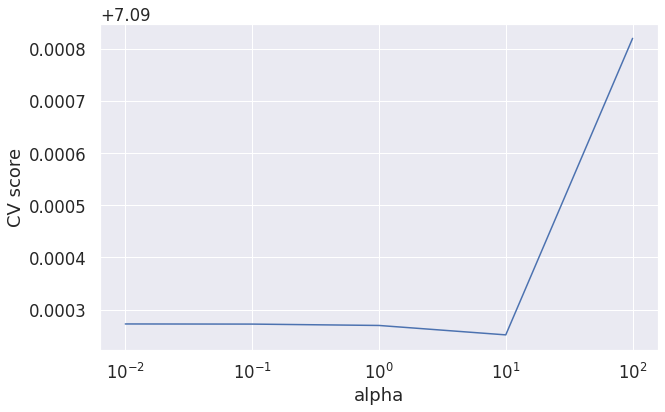

In [523]:
alpha_grid = np.logspace(-2, 2, 5)
searcher = GridSearchCV(Ridge(), [{"alpha": alpha_grid}], scoring="neg_root_mean_squared_error", cv=5)
searcher.fit(X_train_scaled, y_train)

plt.plot(alpha_grid, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [524]:
best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

Best alpha = 10.0000


In [525]:
classifier = MultiOutputRegressor(Ridge(best_alpha))
start_time = time.time()
y_score = classifier.fit(X_train_scaled, y_train).predict(X_test_scaled)
t = (time.time() - start_time)
sc = classifier.score(X_test_scaled, y_test)      
df_result_3.loc['Ridge_MOR_param'] = ['%.3f'%sc, '%.3f'%t]

In [526]:
classifier = RegressorChain(Ridge())
start_time = time.time()
y_score = classifier.fit(X_train_scaled, y_train).predict(X_test_scaled)
t = (time.time() - start_time)
sc = classifier.score(X_test_scaled, y_test)      
df_result_3.loc['Ridge_RC'] = ['%.3f'%sc, '%.3f'%t]

In [527]:
df_result_3

,Score,time
Ridge_MOR,0.259,0.012
Ridge_MOR_param,0.259,0.016
Ridge_RC,0.259,0.006


Из полученных данных видно что ни смена стратегии, ни подбор гиперпараметров, не влияют на величину оценочной метрики. Но лучшее время продемонстрировала стратегия MultiOutputRegressor с подобранным гиперпараметром.